In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json

%matplotlib inline

In [2]:
DATASET_HOME = "/mnt/Enterprise/safal/AI_assisted_microscopy_system/cysts_dataset_all"
SAVE_DIR = "/mnt/Enterprise/safal/AI_assisted_microscopy_system/figures"

os.makedirs(SAVE_DIR, exist_ok=True)


In [3]:
STUDY_SAMPLES = [
    "brightfield_reference",
    "brightfield_sample",
    "smartphone_reference",
    "smartphone_sample",
]


# Total Counts of each category by sample type

In [4]:
category_counts_by_sample_type = pd.DataFrame()
for sample_type in STUDY_SAMPLES:
    sample_home = os.path.join(DATASET_HOME, sample_type)
    annotation_file = os.path.join(sample_home, f"{sample_type}_coco_annos.json")
    with open(annotation_file) as f:
        annotations_json = json.load(f)

    annotations_df = pd.DataFrame(annotations_json["annotations"])
    category_counts_by_sample_type[sample_type] = (
        annotations_df.groupby("image_id")["category_id"]
        .value_counts()
        .unstack()
        .fillna(0)
        .astype(int)
        .sum()
    )


In [5]:
# change indexes 0 and 1 to category names
category_counts_by_sample_type.index = [
    f'{category["name"]}' for category in annotations_json["categories"]
]
category_counts_by_sample_type


,brightfield_reference,brightfield_sample,smartphone_reference,smartphone_sample
Crypto,502,743,534,579
Giardia,907,344,840,320


In [6]:
# get category_id count in each image_id

image_id_category_id_count = (
    annotations_df.groupby("image_id")["category_id"].value_counts().unstack().fillna(0)
)

# rename column names to category names
image_id_category_id_count.columns = [
    f'{category["name"]}' for category in annotations_json["categories"]
]


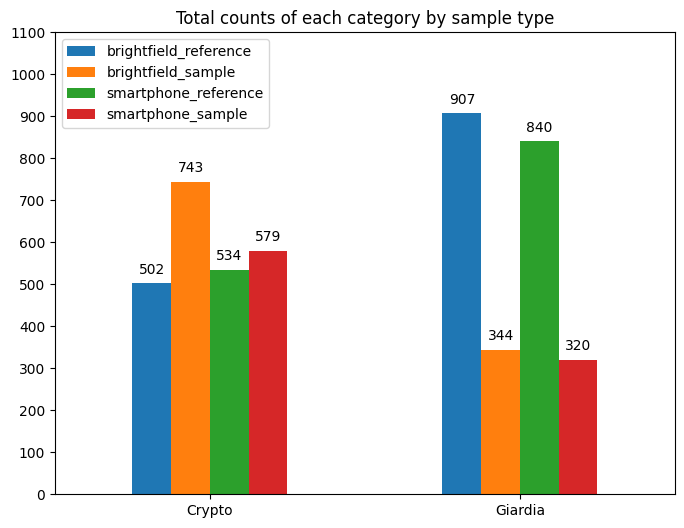

In [8]:
# create bar graph plot of total counts of each category
plot = category_counts_by_sample_type.plot(
    kind="bar",
    title="Total counts of each category by sample type",
    legend=True,
    figsize=(8, 6),
    yticks=np.arange(0, 1200, 100),
    rot=0,
)

# annotate the bars
for p in plot.patches:
    plot.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )

# place the legend at center

# plot.legend(loc='best', bbox_to_anchor=(1, 0.5))

plt.savefig(
    os.path.join(SAVE_DIR, "total_counts_of_each_category_by_sample_type.png"),
    bbox_inches="tight",
    dpi=300,
)


# Count of categories in train and val sets of k-folds

In [100]:
def sample_category_count_df(study_sample, fold, sample_home, type="train"):
    annotation_file = os.path.join(
        sample_home, f"fold_{fold}", f"{study_sample}_coco_annos_{type}.json"
    )
    with open(annotation_file) as f:
        annotations_json = json.load(f)

    annotations_df = (
        pd.DataFrame(annotations_json["annotations"])
        .groupby("image_id")["category_id"]
        .value_counts()
        .unstack()
        .fillna(0)
        .astype(int)
        .sum()
    )
    return annotations_df


def create_category_count_plots_for_folds(sample_type, n_folds, save_dir):
    fig, axes = plt.subplots(
        nrows=1, ncols=n_folds, sharex=True, sharey=True, figsize=(12, 6)
    )
    fig.suptitle(f"Category count in each fold of {sample_type}", fontsize=16)
    for fold in range(1, n_folds + 1):
        category_counts_by_sample_type = pd.DataFrame()
        sample_home = os.path.join(DATASET_HOME, sample_type)
        for type in ["train", "val"]:
            category_counts_by_sample_type[type] = sample_category_count_df(
                sample_type, fold, sample_home, type
            )

        # change indexes 0 and 1 to category names
        category_counts_by_sample_type.index = ["Crypto", "Giardia"]
        plot = category_counts_by_sample_type.plot(
            kind="bar",
            title=f"Fold {fold}",
            rot=0,
            ax=axes[fold - 1],
            stacked=True,
            yticks=np.arange(0, 1200, 100),
        )

        for bar in axes[fold - 1].patches:
            height = bar.get_height()
            width = bar.get_width()
            x = bar.get_x()
            y = bar.get_y()
            label_text = height
            label_x = x + width / 2
            label_y = y + height / 2
            axes[fold - 1].text(
                label_x, label_y, int(label_text), ha="center", va="center"
            )

    plt.tight_layout()
    plt.savefig(
        os.path.join(save_dir, f"{sample_type}_category_count_in_each_fold.png"),
        bbox_inches="tight",
        dpi=300,
    )


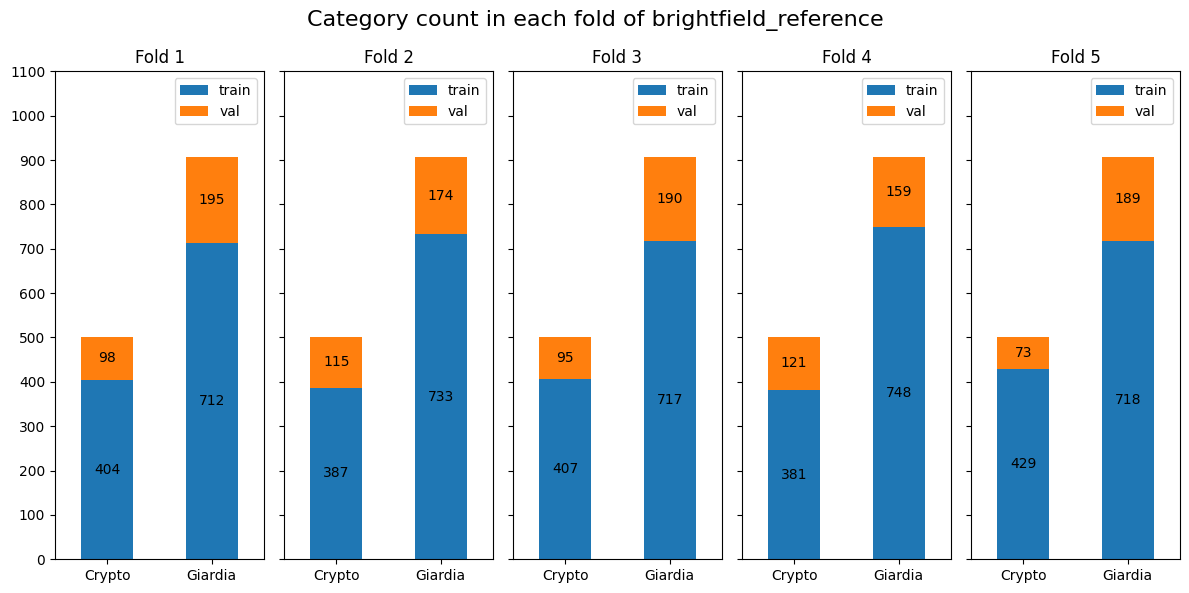

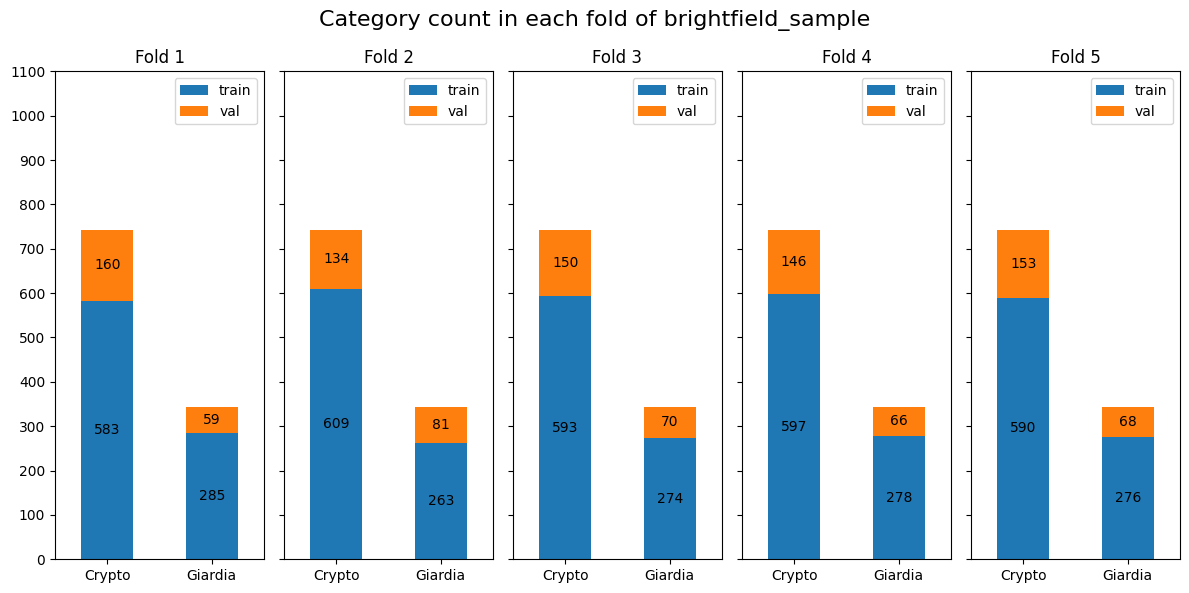

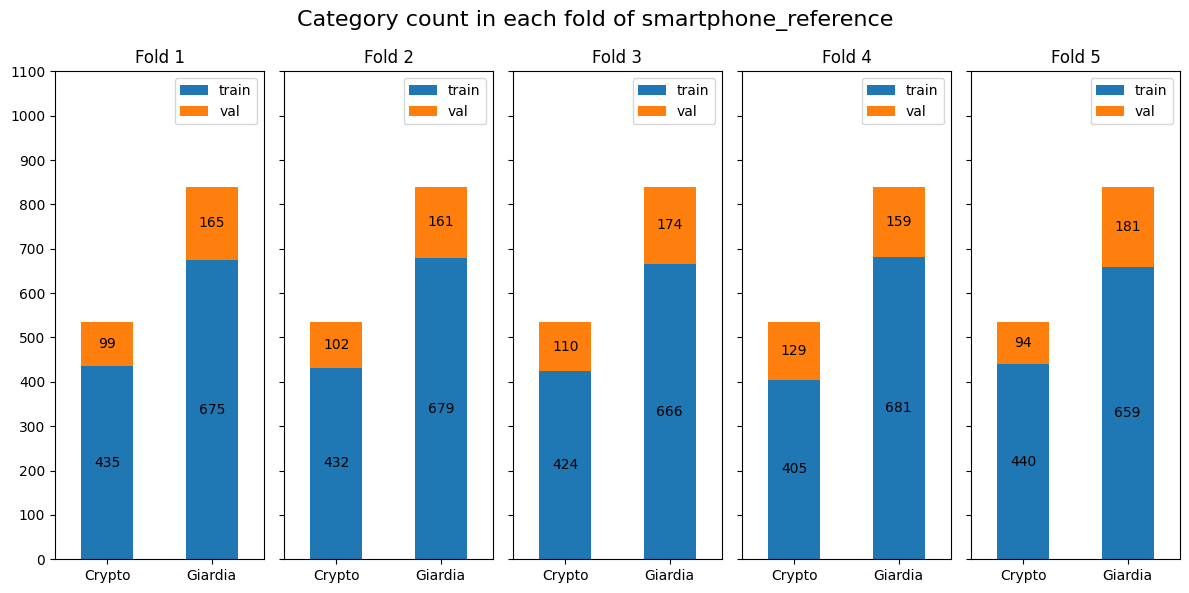

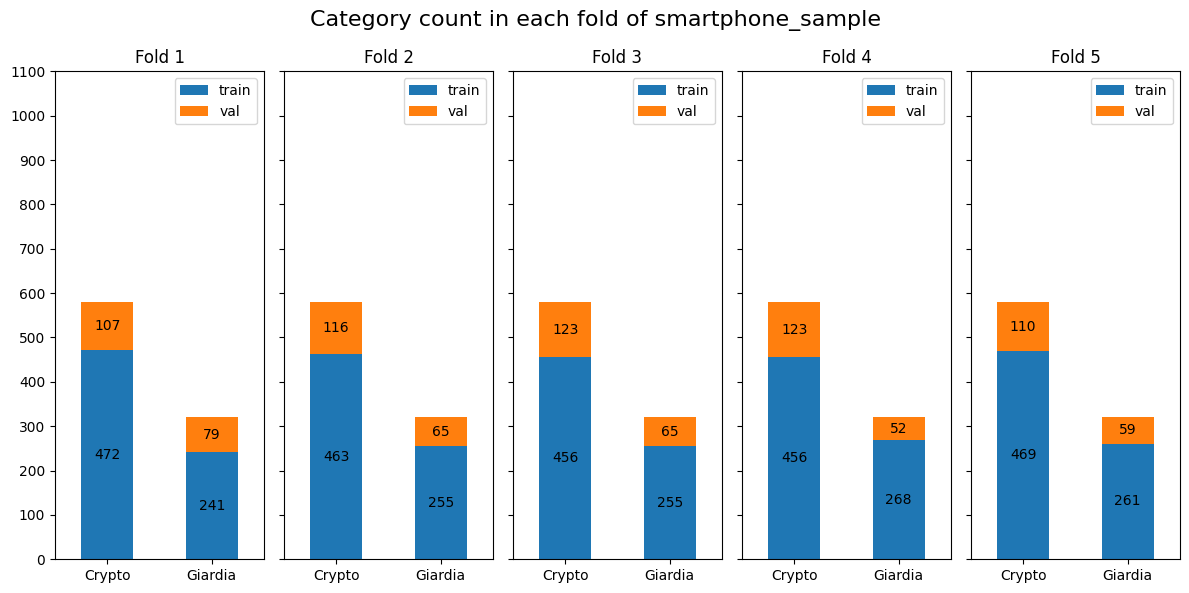

In [101]:
n_folds = 5

for sample_type in STUDY_SAMPLES:
    create_category_count_plots_for_folds(sample_type, n_folds, SAVE_DIR)
